In [3]:
cd ~/data/modl_data/pipeline/contrast/prediction/722/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/722


In [4]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [5]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [6]:
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

pipeline = Pipeline(estimator.steps[:-1])

Using TensorFlow backend.
/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/keras/models.py:150: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T
intercept = b0

ValueError: not enough values to unpack (expected 2, got 1)

In [8]:
print('Sparsity', (coef == 0).sum() / coef.size)

NameError: name 'coef' is not defined

In [9]:
pipeline.named_steps['feature_importance'].feature_importance[:] = 1
maps = pipeline.inverse_transform(coef)

mask = fetch_hcp(n_subjects=1).mask
masker = MultiNiftiMasker(mask_img=mask).fit()
imgs = masker.inverse_transform(maps)

print('Shape', imgs.shape)

NameError: name 'coef' is not defined

In [10]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [11]:
datasets

array(['hcp'], dtype=object)

In [12]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
prediction.loc['train']

predicted_label true_label  \
dataset subject task       contrast  direction                              
hcp     100206  EMOTION    FACES     level2              MATCH      FACES   
                           SHAPES    level2              MATCH     SHAPES   
                GAMBLING   PUNISH    level2             PUNISH     PUNISH   
                           REWARD    level2             PUNISH     REWARD   
                LANGUAGE   MATH      level2           0BK_BODY       MATH   
                           STORY     level2           0BK_BODY      STORY   
                MOTOR      CUE       level2             PUNISH        CUE   
                           LF        level2              MATCH         LF   
                           LH        level2          0BK_PLACE         LH   
                           RF        level2           2BK_TOOL         RF   
                           RH        level2             RANDOM         RH   
                RELATIONAL MATCH     level2             PUNISH      MATCH   
                           REL       level2             PUNISH        REL   
                SOCIAL     RANDOM    level2              STORY     RANDOM   
                           TOM       level2              STORY        TOM   
                WM         0BK_BODY  level2           0BK_BODY   0BK_BODY   
                           0BK_FACE  level2              STORY   0BK_FACE   
                           0BK_PLACE level2              STORY  0BK_PLACE   
                           0BK_TOOL  level2           0BK_BODY   0BK_TOOL   
                           2BK_BODY  level2             PUNISH   2BK_BODY   
                           2BK_FACE  level2             PUNISH   2BK_FACE   
                           2BK_PLACE level2              STORY  2BK_PLACE   
                           2BK_TOOL  level2              STORY   2BK_TOOL   
        100307  EMOTION    FACES     level2          0BK_PLACE      FACES   
                           SHAPES    level2          0BK_PLACE     SHAPES   
                GAMBLING   PUNISH    level2           2BK_TOOL     PUNISH   
                           REWARD    level2                 RF     REWARD   
                LANGUAGE   MATH      level2               MATH       MATH   
                           STORY     level2          0BK_PLACE      STORY   
                MOTOR      CUE       level2              STORY        CUE   
...                                                        ...        ...   
        107321  WM         0BK_FACE  level2          0BK_PLACE   0BK_FACE   
                           0BK_PLACE level2                CUE  0BK_PLACE   
                           0BK_TOOL  level2                CUE   0BK_TOOL   
                           2BK_BODY  level2                TOM   2BK_BODY   
                           2BK_FACE  level2                CUE   2BK_FACE   
                           2BK_PLACE level2              MATCH  2BK_PLACE   
                           2BK_TOOL  level2                CUE   2BK_TOOL   
        107422  EMOTION    FACES     level2           2BK_BODY      FACES   
                           SHAPES    level2           2BK_BODY     SHAPES   
                GAMBLING   PUNISH    level2               MATH     PUNISH   
                           REWARD    level2           0BK_TOOL     REWARD   
                LANGUAGE   MATH      level2                 LF       MATH   
                           STORY     level2                 LF      STORY   
                MOTOR      CUE       level2                 LH        CUE   
                           LF        level2                 RH         LF   
                           LH        level2          0BK_PLACE         LH   
                           RF        level2             RANDOM         RF   
                           RH        level2               MATH         RH   
                RELATIONAL MATCH     level2                 RF      MATCH   
                           REL       level2

In [15]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

In [16]:
plot_confusion_matrix(train_conf, labels)

In [36]:
np.unique(train_conf)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 14])

In [34]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['train']

dataset  task        contrast 
hcp      EMOTION     FACES        0.000000
                     SHAPES       0.000000
         GAMBLING    PUNISH       0.111111
                     REWARD       0.037037
         LANGUAGE    MATH         0.333333
                     STORY        0.000000
         MOTOR       CUE          0.000000
                     LF           0.000000
                     LH           0.074074
                     RF           0.000000
                     RH           0.148148
         RELATIONAL  MATCH        0.000000
                     REL          0.037037
         SOCIAL      RANDOM       0.000000
                     TOM          0.074074
         WM          0BK_BODY     0.037037
                     0BK_FACE     0.074074
                     0BK_PLACE    0.000000
                     0BK_TOOL     0.037037
                     2BK_BODY     0.074074
                     2BK_FACE     0.037037
                     2BK_PLACE    0.000000
                     2B

In [21]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   hcp        0.086957
train  hcp        0.049919
Name: match, dtype: float64

In [26]:
estimator = estimator.steps[-1][1]

In [31]:
estimator.models_[0].layers_by_depth[2][0].get_weights()

[array([[-0.02741276, -0.02432736, -0.02301601, ..., -0.0655942 ,
         -0.05110061,  0.02266686],
        [-0.02334673, -0.01959271,  0.09536425, ...,  0.04013463,
         -0.06840394,  0.00173945],
        [ 0.0535597 ,  0.06267857,  0.04031682, ..., -0.03332284,
          0.04359016, -0.02646653],
        ..., 
        [-0.00044655,  0.00279291, -0.03146969, ..., -0.00193323,
          0.00592736,  0.01187927],
        [-0.0012686 ,  0.0010013 ,  0.01299676, ..., -0.00445125,
         -0.01628286,  0.00859369],
        [ 0.00539562,  0.02723421,  0.01783183, ..., -0.03553556,
          0.00748728,  0.00122301]], dtype=float32)]

In [33]:
estimator.stacked_model_.layers_by_depth[2][0].get_weights()

[array([[-0.02741276, -0.02432736, -0.02301601, ..., -0.0655942 ,
         -0.05110061,  0.02266686],
        [-0.02334673, -0.01959271,  0.09536425, ...,  0.04013463,
         -0.06840394,  0.00173945],
        [ 0.0535597 ,  0.06267857,  0.04031682, ..., -0.03332284,
          0.04359016, -0.02646653],
        ..., 
        [-0.00044655,  0.00279291, -0.03146969, ..., -0.00193323,
          0.00592736,  0.01187927],
        [-0.0012686 ,  0.0010013 ,  0.01299676, ..., -0.00445125,
         -0.01628286,  0.00859369],
        [ 0.00539562,  0.02723421,  0.01783183, ..., -0.03553556,
          0.00748728,  0.00122301]], dtype=float32)]

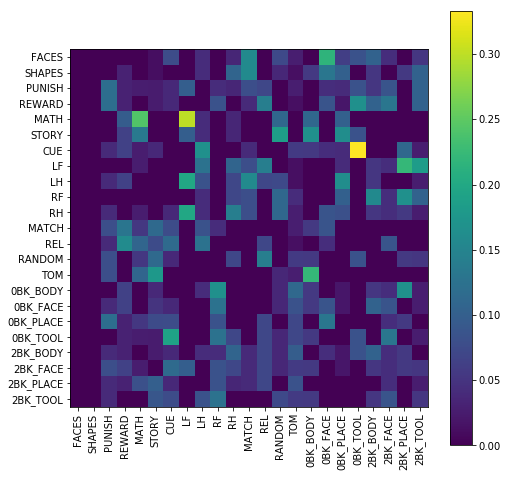

In [19]:
plt.show()

In [707]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [619]:
np.mean(w0 == 0),np.mean(w1 == 0)

(0.0, 0.0)

In [620]:
np.histogram(w1)

(array([   34,   223,  1099,  4358,  8492, 10087,  6574,  2116,   493,   124]),
 array([ -5.41468558e-04,  -4.37985052e-04,  -3.34501546e-04,
         -2.31018040e-04,  -1.27534533e-04,  -2.40510271e-05,
          7.94324791e-05,   1.82915985e-04,   2.86399492e-04,
          3.89882998e-04,   4.93366504e-04]))

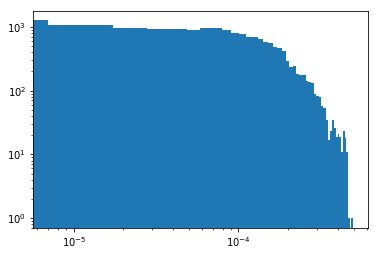

In [623]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)